In [1]:
import numpy as np

from IPython.display import clear_output
from threading import Thread
from time import sleep
from enum import Enum
from matplotlib import pyplot as plt

In [14]:
nums_after_points = 6

intensity_min = 0.4
service_time_min = 3

sec_multiplier = 0.05
intensity = intensity_min  # intensity_min / 60.
service_time = service_time_min  # service_time_min * 60

theor_alpha = intensity_min * service_time_min
theor_A = intensity_min / (1 + theor_alpha)
theor_Q = 1 / (1 + theor_alpha)
theor_pn = theor_alpha / (1 + theor_alpha)
theor_p_rej = theor_alpha / (1 + theor_alpha)
theor_p0 = 1 - theor_pn

def wait(sec):
    sleep(sec * sec_multiplier)
    
    
TOTAL_REQUESTS = 'total_requests'
COMPLETED_REQUESTS = 'completed_requests'
REJECTED_REQUESTS = 'rejected_requests'
CURRENT_TIME = 'current_time'
TIME_WORKED = 'time_worked'
TIME_FREE = 'time_free'

def get_stats(timer, cmo):
    return {
        CURRENT_TIME: timer.current_time, 
        TOTAL_REQUESTS: cmo.total_requests,
        COMPLETED_REQUESTS: cmo.completed_requests,
        REJECTED_REQUESTS: cmo.rejected_requests,
        TIME_WORKED: cmo.time_worked,
        TIME_FREE: cmo.time_free,
    }

In [15]:
class CMO:
    def __init__(self):
        self.processing_request = False
        self.init_stats_items()
        self.init_working_items()
        
    
    def init_stats_items(self):
        self.completed_requests = 0
        self.rejected_requests = 0
        self.total_requests = 0
        self.time_worked = 0
        self.time_free = 0

    
    def init_working_items(self):
        self.working = False
        self.worker: Thread

    
    def handle_tick(self):
        if self.processing_request:
            self.time_worked += 1
            return
        self.time_free += 1
        
    
    def start(self):
        self.init_stats_items()
        self.working = True
        self.worker = Thread(target=self.count_time)
        self.worker.start()
        
    def count_time(self):
        while self.working:
            wait(1)
            if self.processing_request:
                self.time_worked += 1
                continue
            self.time_free += 1
            
        
    def stop(self):
        self.working = False
    
    
    def process_request(self, request):        
        if not self.working:
            return
        
        self.total_requests += 1
        
        if not self.processing_request:
            self.accept_request(request)
            return
        
        self.reject_request(request)        
    
    
    def accept_request(self, request):
        self.processing_request = True
        request.proceed(self.completed_request_callback)
        
        
    def completed_request_callback(self):
        self.completed_requests += 1
        self.processing_request = False
    
    
    def reject_request(self, request):
        request.rejected()
        self.rejected_requests += 1
    
    
class Status(Enum):
        NONE = 0
        REJECTED = 1
        COMPLETED = 2    

        
class Request:
    def __init__(self, is_random_service_time=True, after_proceed_callback=None):
        self.status = Status.NONE
        self.service_time = np.random.exponential(service_time) if is_random_service_time else service_time
        self.after_proceed_callback = after_proceed_callback
        
    
    def __proceed(self, callback=None):
        wait(self.service_time)
        self.status = Status.COMPLETED
        if callback:
            callback()
            
        if self.after_proceed_callback:
            self.after_proceed_callback()
    
        
    def proceed(self, callback=None):
        Thread(target=self.__proceed, args=(callback,)).start()
        
        
    def rejected(self):
        self.status = Status.REJECTED
        
        
class RequestSender():
    def __init__(self, cmo, is_random_request_send=True):
        self.working = False
        self.cmo = cmo
        self.worker: Thread
        self.send_one_request = not is_random_request_send
        self.set_random_or_not_sending(is_random_request_send)
        
    
    def set_random_or_not_sending(self, is_random_request_send):        
        if is_random_request_send:
            def create_request():
                return Request() if np.random.uniform() < intensity else None
            self.create_request = create_request
            self.time_step = 1
        else:           
            def create_request():
                return Request(False, self.send_request)
            self.create_request = create_request
            self.time_step = service_time
            
        
    def start(self):
        self.working = True
        self.worker = Thread(target=self.sending)
        self.worker.start()
        
        
    def sending(self):
        if self.send_one_request:
            self.send_request()
            return
        
        while self.working:
            wait(self.time_step)
            self.send_request()
            
            
    def stop(self):
        self.working = False
    
            
    def send_request(self):       
        request = self.create_request()
        if not request:
            return
        self.cmo.process_request(request)    
    
    
class Timer:
    def __init__(self):
        self.tick_handlers = []
        self.worker: Thread
        self.working = False
        self.current_time = 0
        self.time_step = 1
    
    
    def add_handler(self, handler):
        self.tick_handlers.append(handler)
    
    
    def tick(self):
        
        while self.working:
            for handler in self.tick_handlers:
                handler()
            wait(self.time_step)
            self.current_time += self.time_step
    
    
    def start(self):
        self.current_time = 0
        self.working = True
        self.worker = Thread(target=self.tick)
        self.worker.start()
        
        
    def stop(self):
        self.working = False
        
        
    def clear_handlers(self):
        self.tick_handlers = []
        
def print_stats(field_for_A, sender, cmo, timer):
    while sender.working and cmo.working and timer.working:
        sleep(0.5)
        clear_output(wait=True)
        stats = get_stats(timer, cmo)

        print(f'{stats}\n')

        current_time = stats[CURRENT_TIME]
        total_requests = stats[TOTAL_REQUESTS]
        completed_requests = stats[COMPLETED_REQUESTS]
        rejected_requests = stats[REJECTED_REQUESTS]
        time_worked = stats[TIME_WORKED]
        time_free = stats[TIME_FREE]
#         print(f'{total_requests = } \n')

        try:
            emp_intensity = total_requests / current_time
            emp_alpha = emp_intensity * service_time_min
            emp_p0 = time_free / current_time  # 1 / (1 + emp_alpha)
            emp_pn = time_worked / current_time  # emp_alpha / (1 + emp_alpha)
            emp_A = emp_intensity / (1 + emp_alpha)
            emp_Q = 1 / (1 + emp_alpha)
            emp_p_rej = emp_pn
            
            global_stats['cmo_common']['intensity'] = emp_intensity
            global_stats['cmo_common']['p0'] = emp_p0
            global_stats['cmo_common']['pn'] = emp_pn
            global_stats['cmo_common']['A'] = emp_A
            global_stats['cmo_common']['Q'] = emp_Q
            global_stats['cmo_common']['p_rej'] = emp_p_rej
            
            
            global_stats[field_for_A] = emp_A
            
            print(f'(Theor, Emp)\nintensity: ({round(intensity_min, nums_after_points)}, {round(emp_intensity, nums_after_points)})')
            print(f'p0: ({round(theor_p0, nums_after_points)}, {round(emp_p0, nums_after_points)})')
            print(f'pn: ({round(theor_pn, nums_after_points)}, {round(emp_pn, nums_after_points)})')
            print(f'A: ({round(theor_A, nums_after_points)}, {round(emp_A, nums_after_points)})')
            print(f'Q: ({round(theor_Q, nums_after_points)}, {round(emp_Q, nums_after_points)})')
            print(f'p_rej: ({round(theor_p_rej, nums_after_points)}, {round(emp_p_rej, nums_after_points)})')
        except ZeroDivisionError:
            ...
        if current_time > 100_000:
            break

def print_stats2(field_for_A, sender, cmo, timer):
    while sender.working and cmo.working and timer.working:
        sleep(0.5)
        clear_output(wait=True)
        stats = get_stats(timer, cmo)

        print(f'{stats}\n')

        current_time = stats[CURRENT_TIME]
        total_requests = stats[TOTAL_REQUESTS]
        completed_requests = stats[COMPLETED_REQUESTS]
        rejected_requests = stats[REJECTED_REQUESTS]
        time_worked = stats[TIME_WORKED]
        time_free = stats[TIME_FREE]
#         print(f'{total_requests = } \n')

        try:
            emp_intensity = total_requests / current_time
            emp_alpha = emp_intensity * service_time_min
            emp_p0 = time_free / current_time  # 1 / (1 + emp_alpha)
            emp_pn = time_worked / current_time  # emp_alpha / (1 + emp_alpha)
            emp_A = emp_intensity / (1 + emp_alpha)
            emp_Q = 1 / (1 + emp_alpha)
            emp_p_rej = emp_pn
            
            global_stats['cmo_nominal']['intensity'] = emp_intensity
            global_stats['cmo_nominal']['A'] = emp_A
            global_stats['cmo_nominal']['Q'] = emp_Q
            
            global_stats[field_for_A] = emp_A
            
            print(f'(Theor, Emp)\nintensity: ({round(intensity_min, nums_after_points)}, {round(emp_intensity, nums_after_points)})')
            print(f'A: ({round(theor_A, nums_after_points)}, {round(emp_A, nums_after_points)})')
            print(f'Q: ({round(theor_Q, nums_after_points)}, {round(emp_Q, nums_after_points)})')
        except ZeroDivisionError:
            ...
        if current_time > 100_000:
            break

In [16]:
def start():
    cmo = CMO()
    sender = RequestSender(cmo)
    timer = Timer()

    timer.start()
    cmo.start()
    sender.start()

    return sender, cmo, timer

def start_without_random():
    cmo = CMO()
    sender = RequestSender(cmo, False)
    timer = Timer()

    timer.start()
    cmo.start()
    sender.start()

    return sender, cmo, timer

global_stats = {'cmo_common': {}, 'cmo_nominal': {}}

In [21]:
args = start()
t = Thread(target=print_stats, args=('A', *args))
t.start()

{'current_time': 5315, 'total_requests': 2185, 'completed_requests': 1101, 'rejected_requests': 1084, 'time_worked': 3068, 'time_free': 2247}

(Theor, Emp)
intensity: (0.4, 0.411101)
p0: (0.454545, 0.422766)
pn: (0.545455, 0.577234)
A: (0.181818, 0.184078)
Q: (0.454545, 0.447767)
p_rej: (0.545455, 0.577234)


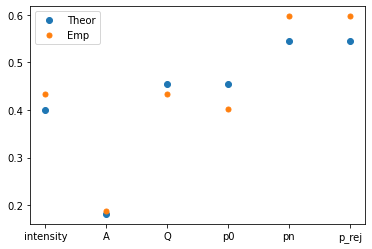

In [18]:
for arg in args:
    arg.stop()
    
sleep(0.6)
clear_output()

characteristics_common = ['intensity', 'A', 'Q', 'p0', 'pn', 'p_rej']
plt.xticks(range(0, len(characteristics_common)), characteristics_common)
plt.plot([intensity, theor_A, theor_Q, theor_p0, theor_pn, theor_p_rej], 'o', label='Theor')
plt.plot([global_stats['cmo_common'][key] for key in characteristics_common], 'o', label='Emp', markersize=5)
plt.legend()
plt.show()

In [19]:
args2 = start_without_random()
t = Thread(target=print_stats2, args=('A_nominal', *args2))
t.start()

{'current_time': 458, 'total_requests': 164, 'completed_requests': 163, 'rejected_requests': 0, 'time_worked': 459, 'time_free': 0}

(Theor, Emp)
intensity: (0.4, 0.358079)
A: (0.181818, 0.172632)
Q: (0.454545, 0.482105)


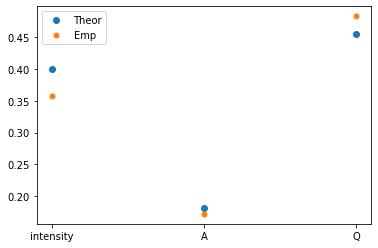

In [20]:
for arg in args2:
    arg.stop()

sleep(0.6)
clear_output()

characteristics_nominal = ['intensity', 'A', 'Q']
plt.xticks(range(0, len(characteristics_nominal)), characteristics_nominal)
plt.plot([intensity, theor_A, theor_Q], 'o', label='Theor')
plt.plot([global_stats['cmo_nominal'][key] for key in characteristics_nominal], 'o', label='Emp', markersize=5)
plt.legend()
plt.show()

In [9]:
print(f"A: {global_stats['A']}\nA nominal: {global_stats['A_nominal']}")

A: 0.18067226890756305
A nominal: 0.17653508771929824
